In [1]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

In [2]:
# 生成一个简单的人⼯训练数据集
#输入个数（特征数）为2
num_inputs = 2
#训练数据集样本数为1000
num_examples = 1000
#真实权重w
true_w = [2, -3.4]
#真实偏差b
true_b = 4.2
# features 的每一⾏是一个长度为2的向量。随机⽣成的批量样本特征（服从标准正态分布）
features = torch.from_numpy(np.random.normal(0, 1, (num_examples,num_inputs)))
#真实labels 的每一⾏是一个⻓度为1的向量（标量），y=WX+b
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
# 加入噪声项e服从均值为0、标准差为0.01的正态分布。噪声代表了数据集中⽆意义的⼲扰。
labels += torch.from_numpy(np.random.normal(0, 0.01,size=labels.size()))

In [3]:
#随机生成的第一个样本的特征向量和目标值
print(features[0], labels[0])

tensor([0.2539, 0.3733], dtype=torch.float64) tensor(3.4279, dtype=torch.float64)


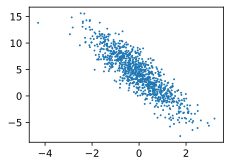

In [4]:
# 通过生成第二个特征 features[:, 1] 和标签 labels 的散点图，可以更直观地观察两者间的线性关系。
def use_svg_display():
    # ⽤矢量图显示
    display.set_matplotlib_formats('svg')
def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺⼨
    plt.rcParams['figure.figsize'] = figsize
# # 在../d2lzh_pytorch⾥里里⾯面添加上⾯面两个函数后就可以这样导⼊入
# import sys
# sys.path.append("..")
# from d2lzh_pytorch import *
set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

In [5]:
# 在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本。这里我们定义一个函数：它每次返回 batch_size （批量大小）个随机样本的特征和标签。
# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)#总的样本数量1000
    indices = list(range(num_examples))#构建长度为1000的列表[0,1,2....999]
    random.shuffle(indices) # 样本的读取顺序是随机的，如[55,67,5,2,999,.......]
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size,num_examples)]) # 最后一次可能不⾜一个batch
        yield features.index_select(0, j), labels.index_select(0,j)

In [6]:
# 让我们读取第一个小批量数据样本并打印。每个批量的特征形状为(10, 2)，分别对应批量⼤小和输入个数；标签形状为批量⼤小。
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[ 1.2348, -1.0446],
        [-0.3903,  1.3874],
        [-1.6890,  1.7134],
        [ 1.0992,  0.0601],
        [-0.3396,  0.6958],
        [-0.6690,  1.0484],
        [ 0.1891,  1.2095],
        [-1.3607, -0.2705],
        [ 0.9397,  0.4587],
        [-0.9757, -1.3688]], dtype=torch.float64) tensor([10.2248, -1.2956, -4.9950,  6.1901,  1.1617, -0.7038,  0.4641,  2.3954,
         4.5182,  6.8858], dtype=torch.float64)


In [7]:
# 我们将权重初始化成均值为0、标准差为0.01的正态随机数，偏差则初始化成0。
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)),dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

In [8]:
# 之 后 的 模 型 训 练 中 ， 需 要 对 这 些 参 数 求 梯 度 来 迭 代 参 数 的 值 ， 因 此 我 们 要 让 它 们 的requires_grad=True 。
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

In [9]:
# 下⾯是线性回归的⽮量计算表达式的实现。我们使⽤ mm 函数做矩阵乘法。
def linreg(X, w, b): # 本函数已保存在d2lzh_pytorch包中方便以后使用
    X = X.float()#原书中的bug，扈晓君调试出。需要转换数字类型。
    w = w.float()
    b = b.float()
    return torch.mm(X, w) + b

In [10]:
# 3.2.5 定义损失函数
# 我们使用上一节描述的平方损失来定义线性回归的损失函数。在实现中，我们需要把真实值 y 变形成预测值 y_hat 的形状。以下函数返回的结果也将和 y_hat 的形状相同。
def squared_loss(y_hat, y): # 本函数已保存在d2lzh_pytorch包中方便以后使用
    # 注意这里返回的是向量, 另外, pytorch里的MSELoss并没有除以 2
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

In [11]:
# 3.2.6 定义优化算法
# 以下的 sgd 函数实现了上一节中介绍的小批量随机梯度下降算法。它通过不断迭代模型参数来优化损失函数。
# 这里自动求梯度模块计算得来的梯度是一个批量样本的梯度和。我们将它除以批量⼤小来得到平均值。
def sgd(params, lr, batch_size): # 本函数已保存在d2lzh_pytorch包中⽅便以后使⽤
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data

In [12]:
lr = 0.03#学习率
num_epochs = 3#迭代次数
net = linreg#使用线性回归算法
loss = squared_loss#损失函数
for epoch in range(num_epochs): # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量⼤小整除）。X和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
#         l = loss(net(X, w, b), y) # l是有关小批量X和y的损失
#         l.backward(torch.ones(l.size()))
        l = loss(net(X, w, b), y).sum()# l是有关小批量X和y的损失
        l.backward() # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size) # 使用小批量随机梯度下降迭代模型参数
        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print(w,b)
    print('epoch迭代次数： %d, loss平均损失： %f' % (epoch + 1, train_l.mean().item()))

tensor([[ 1.8740],
        [-3.2647]], requires_grad=True) tensor([4.0050], requires_grad=True)
epoch迭代次数： 1, loss平均损失： 0.035844
tensor([[ 1.9921],
        [-3.3942]], requires_grad=True) tensor([4.1903], requires_grad=True)
epoch迭代次数： 2, loss平均损失： 0.000140
tensor([[ 1.9992],
        [-3.3990]], requires_grad=True) tensor([4.1995], requires_grad=True)
epoch迭代次数： 3, loss平均损失： 0.000049


In [13]:
# 训练完成后，我们可以比较学到的参数和用来生成训练集的真实参数。它们应该很接近。
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 1.9992],
        [-3.3990]], requires_grad=True)
4.2 
 tensor([4.1995], requires_grad=True)
